# 1. Environment Setup & Imports

In [1]:
# ============================
# 1) ENVIRONMENT SETUP & IMPORTS
# ============================

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install YOLOv5 dependencies
!pip install -r requirements.txt

# Go back to the root directory (so we can organize code more easily)
%cd /content

# Add yolov5 to Python path for easy imports
import sys
sys.path.append('/content/yolov5')

# Standard libraries
import os
import random
import shutil
import scipy.io
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# For YOLOv5
from yolov5.models.common import DetectMultiBackend
from yolov5.models.experimental import attempt_load

# For torchvision models (VGG19, etc.)
import torchvision.models as models

# Set global seed for reproducibility
#SEED = 42
#random.seed(SEED)
#np.random.seed(SEED)
#torch.manual_seed(SEED)
#if torch.cuda.is_available():
#    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Print to confirm
print("Setup complete. Using torch version:", torch.__version__)

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17270/17270), 16.12 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (11858/11858), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00

# 2. Data Download & Organization

Below we define functions to organize the Oxford 102 Flowers dataset into class folders. Then we’ll download the dataset and apply these functions.

In [2]:
# ============================
# 2) DATA DOWNLOAD & ORGANIZATION
# ============================

def organize_by_class(image_dir, label_file, output_dir):
    """
    Organize images into class-labeled folders based on the imagelabels.mat file.
    """
    import scipy.io
    os.makedirs(output_dir, exist_ok=True)
    labels = scipy.io.loadmat(label_file)['labels'][0]
    for i, label in enumerate(labels):
        class_dir = os.path.join(output_dir, f"class_{label}")
        os.makedirs(class_dir, exist_ok=True)
        image_name = f"image_{i + 1:05d}.jpg"
        shutil.move(os.path.join(image_dir, image_name), os.path.join(class_dir, image_name))
    print(f"Images organized into {len(set(labels))} classes.")

# Download the Flowers 102 dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!tar -xvzf 102flowers.tgz

# Organize images by class
organize_by_class("jpg", "imagelabels.mat", "organized_data")

print("Dataset downloaded and organized successfully!")

Streaming output truncated to the last 5000 lines.
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image_07640.jpg
jpg/image_04883.jpg
jpg/image

# 3. Dataset Preparation (Fixed Test Set + Multiple Train/Val Splits)

We define a function to split the dataset into train, val, and test sets. We create one fixed test set (25%) and then multiple train/val splits (50%/25%) for repeated experiments.

In [3]:
# ============================
# 3) DATASET PREPARATION
# ============================

def prepare_dataset_fixed_test(data_dir, output_dir, train_ratio=0.5, val_ratio=0.25, num_splits=2):
    """
    Creates one fixed test set (25%) across multiple random splits (each has train=50%, val=25%).
    Ensures no overlap between the fixed test set and any train/val split.
    """
    os.makedirs(output_dir, exist_ok=True)
    classes = os.listdir(data_dir)

    # ----------------------------------------
    # 1) Create a fixed test set (only once)
    # ----------------------------------------
    test_set_dir = os.path.join(output_dir, "fixed_test")
    # We'll store which images ended up in the test set for each class
    test_images_dict = {}  # {class_name: [list_of_test_images]}

    if not os.path.exists(test_set_dir):
        os.makedirs(test_set_dir, exist_ok=True)
        for cls in classes:
            class_dir = os.path.join(data_dir, cls)
            images = os.listdir(class_dir)
            random.shuffle(images)

            # Calculate 25% for test (since train=50%, val=25%, test=25%)
            num_test = int((1 - train_ratio - val_ratio) * len(images))
            test_images = images[:num_test]
            test_images_dict[cls] = test_images

            # Copy test images to the fixed_test folder
            fixed_test_class_dir = os.path.join(test_set_dir, cls)
            os.makedirs(fixed_test_class_dir, exist_ok=True)
            for img in test_images:
                src = os.path.join(class_dir, img)
                dst = os.path.join(fixed_test_class_dir, img)
                shutil.copy(src, dst)
    else:
        # If the fixed_test folder exists, read which images are already in it.
        # This ensures the test set is truly "fixed" across reruns.
        for cls in classes:
            fixed_test_class_dir = os.path.join(test_set_dir, cls)
            if os.path.exists(fixed_test_class_dir):
                test_images_dict[cls] = os.listdir(fixed_test_class_dir)
            else:
                test_images_dict[cls] = []

    # ----------------------------------------
    # 2) Create multiple random splits for train/val
    # ----------------------------------------
    for split_idx in range(num_splits):
        split_dir = os.path.join(output_dir, f"train_val_split_{split_idx}")
        os.makedirs(split_dir, exist_ok=True)

        for cls in classes:
            class_dir = os.path.join(data_dir, cls)
            all_images = os.listdir(class_dir)

            # Exclude any images that belong to the fixed test set for this class
            test_images_set = set(test_images_dict[cls])
            remaining_images = [img for img in all_images if img not in test_images_set]

            random.shuffle(remaining_images)

            # Calculate how many go to train/val from the remaining images
            num_train = int(train_ratio * len(remaining_images))  # 50%
            num_val   = int(val_ratio * len(remaining_images))    # 25%

            train_imgs = remaining_images[:num_train]
            val_imgs   = remaining_images[num_train : num_train + num_val]

            # Copy train images
            train_dir = os.path.join(split_dir, "train", cls)
            os.makedirs(train_dir, exist_ok=True)
            for img in train_imgs:
                src = os.path.join(class_dir, img)
                dst = os.path.join(train_dir, img)
                shutil.copy(src, dst)

            # Copy val images
            val_dir = os.path.join(split_dir, "val", cls)
            os.makedirs(val_dir, exist_ok=True)
            for img in val_imgs:
                src = os.path.join(class_dir, img)
                dst = os.path.join(val_dir, img)
                shutil.copy(src, dst)

    print("Dataset prepared with a fixed test set and multiple random train/val splits (no overlap).")

# Actually prepare the dataset
prepare_dataset_fixed_test("organized_data", "flower_data", train_ratio=0.5, val_ratio=0.25, num_splits=3)
print("Data splits created (train=50%, val=25%, test=25%).")

Dataset prepared with a fixed test set and multiple random train/val splits (no overlap).
Data splits created (train=50%, val=25%, test=25%).


# 4. Common Utility Functions

We’ll define a few utility functions for:

* **Hyperparameter Tuning** (training on train set, evaluating on val set, returning final val accuracy).
* **Final Training** (training for multiple epochs, tracking train/val/test accuracy & loss each epoch).
* **Plotting** (plots train/val/test accuracy & loss vs. epoch).

In [4]:
# ====================================================
# 4) COMMON UTILITY FUNCTIONS
# ====================================================

def train_for_tuning(build_model_func, tuning_epochs, train_loader, val_loader, device, lr=0.001):
    """
    Build a model using `build_model_func(num_classes, lr, device)`,
    train for 'tuning_epochs' on the train set,
    return final validation accuracy (no test usage here).
    """
    num_classes = len(train_loader.dataset.classes)
    model, criterion, optimizer = build_model_func(num_classes, lr, device)

    # Train for a small number of epochs
    model.train()
    for _ in range(tuning_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on val
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    val_acc = correct / total
    return val_acc

def hyperparam_tuning(build_model_func, train_data, val_data, device, tuning_epochs=3):
    """
    Generic hyperparam tuning loop. By default, we do 'tuning_epochs=3'.
    Returns (best_lr, best_batch_size).
    """
    possible_lrs = [0.01, 0.001, 0.0001]
    possible_bsizes = [16, 32]

    best_val_acc = 0.0
    best_lr = None
    best_bs = None

    for lr in possible_lrs:
        for bs in possible_bsizes:
            train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
            val_loader   = DataLoader(val_data,   batch_size=bs, shuffle=False)

            val_acc = train_for_tuning(build_model_func, tuning_epochs, train_loader, val_loader, device, lr=lr)
            print(f"[Tuning] lr={lr}, bs={bs}, val_acc={val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_lr = lr
                best_bs = bs

    print(f"Best Hyperparams => LR={best_lr}, BatchSize={best_bs}, ValAcc={best_val_acc:.4f}")
    return best_lr, best_bs

def final_train_and_evaluate(build_model_func, final_epochs, train_loader, val_loader, test_loader, device, lr=0.001):
    """
    Train from scratch using the best HP, for 'final_epochs'.
    Returns (train_losses, val_losses, test_losses, train_accs, val_accs, test_accs).
    """
    num_classes = len(train_loader.dataset.classes)
    model, criterion, optimizer = build_model_func(num_classes, lr, device)

    # StepLR that drops LR by factor of 0.1 every 4 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    train_losses, val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []

    for epoch in range(final_epochs):
        # -------- TRAIN --------
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_train_loss / total_train
        epoch_train_acc = correct_train / total_train

        # -------- VALIDATION --------
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val

        # -------- TEST --------
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        epoch_test_loss = running_test_loss / total_test
        epoch_test_acc = correct_test / total_test

        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        test_losses.append(epoch_test_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        test_accs.append(epoch_test_acc)

        print(f"[Epoch {epoch+1}/{final_epochs}] "
              f"TrainLoss={epoch_train_loss:.4f}, TrainAcc={epoch_train_acc:.4f} | "
              f"ValLoss={epoch_val_loss:.4f},   ValAcc={epoch_val_acc:.4f} | "
              f"TestLoss={epoch_test_loss:.4f}, TestAcc={epoch_test_acc:.4f}")

        # Step the scheduler
        scheduler.step()

    return (train_losses, val_losses, test_losses,
            train_accs,   val_accs,   test_accs)

def plot_splits_results(splits_results, model_name="Model"):
    """
    splits_results: List[Dict], each dict has:
      "train_losses", "val_losses", "test_losses",
      "train_accs",   "val_accs",   "test_accs"
    We'll plot per-split curves and the average across all splits.
    """
    num_splits = len(splits_results)
    # We'll assume each split has the same number of epochs
    final_epochs = len(splits_results[0]["train_accs"])
    x_axis = np.arange(1, final_epochs+1)

    %matplotlib inline

    # 1) Plot each split's ACCURACY
    for i, split_dict in enumerate(splits_results):
        plt.figure(figsize=(8,5))
        plt.plot(x_axis, split_dict["train_accs"], label="Train Acc", marker='o')
        plt.plot(x_axis, split_dict["val_accs"],   label="Val Acc",   marker='x')
        plt.plot(x_axis, split_dict["test_accs"],  label="Test Acc",  marker='s')
        plt.title(f"{model_name} Accuracy vs. Epoch (Split {i})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    # 2) Average Accuracy across splits
    avg_train_accs = []
    avg_val_accs   = []
    avg_test_accs  = []
    for epoch in range(final_epochs):
        sum_train = sum(res["train_accs"][epoch] for res in splits_results)
        sum_val   = sum(res["val_accs"][epoch]   for res in splits_results)
        sum_test  = sum(res["test_accs"][epoch]  for res in splits_results)
        avg_train_accs.append(sum_train / num_splits)
        avg_val_accs.append(sum_val / num_splits)
        avg_test_accs.append(sum_test / num_splits)

    plt.figure(figsize=(8,5))
    plt.plot(x_axis, avg_train_accs, label="Train Acc", marker='o')
    plt.plot(x_axis, avg_val_accs,   label="Val Acc",   marker='x')
    plt.plot(x_axis, avg_test_accs,  label="Test Acc",  marker='s')
    plt.title(f"{model_name} Average Accuracy vs. Epoch (All Splits)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3) Plot each split's LOSS
    for i, split_dict in enumerate(splits_results):
        plt.figure(figsize=(8,5))
        plt.plot(x_axis, split_dict["train_losses"], label="Train Loss", marker='o')
        plt.plot(x_axis, split_dict["val_losses"],   label="Val Loss",   marker='x')
        plt.plot(x_axis, split_dict["test_losses"],  label="Test Loss",  marker='s')
        plt.title(f"{model_name} Loss vs. Epoch (Split {i})")
        plt.xlabel("Epoch")
        plt.ylabel("Cross-Entropy Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    # 4) Average Loss across splits
    avg_train_losses = []
    avg_val_losses   = []
    avg_test_losses  = []
    for epoch in range(final_epochs):
        sum_train_l = sum(res["train_losses"][epoch] for res in splits_results)
        sum_val_l   = sum(res["val_losses"][epoch]   for res in splits_results)
        sum_test_l  = sum(res["test_losses"][epoch]  for res in splits_results)
        avg_train_losses.append(sum_train_l / num_splits)
        avg_val_losses.append(sum_val_l / num_splits)
        avg_test_losses.append(sum_test_l / num_splits)

    plt.figure(figsize=(8,5))
    plt.plot(x_axis, avg_train_losses, label="Train Loss", marker='o')
    plt.plot(x_axis, avg_val_losses,   label="Val Loss",   marker='x')
    plt.plot(x_axis, avg_test_losses,  label="Test Loss",  marker='s')
    plt.title(f"{model_name} Average Loss vs. Epoch (All Splits)")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Model Builders

## 5.1 VGG19 Builder

In [5]:
# ====================================================
# 5.1) MODEL BUILDER: VGG19
# ====================================================

def build_model_vgg19(num_classes, lr, device):
    """
    Build a VGG19 model (pretrained on ImageNet), freeze features,
    replace final classifier layer, return (model, criterion, optimizer).
    """
    model = models.vgg19(pretrained=True)

    # Freeze feature layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace final classifier layer
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, criterion, optimizer


## 5.2 YOLOv5 Builder

In [6]:
# ====================================================
# 5.2) MODEL BUILDER: YOLOv5 (Classification)
# ====================================================

def build_model_yolov5(num_classes, lr, device, model_path="/mnt/yolov5s-cls.pt"):
    """
    Build a YOLOv5 classification model from the provided classification checkpoint.
    Freeze all layers except the final linear, then return (model, criterion, optimizer).
    """
    # Load YOLOv5 classification checkpoint
    detect_model = DetectMultiBackend(model_path, device=device, dnn=False, data=None, fp16=False)
    model_pt = attempt_load(model_path, device=device)

    # Freeze everything except final layer
    for name, param in model_pt.named_parameters():
        if "linear" not in name:
            param.requires_grad = False

    # Modify final linear layer
    in_features = model_pt.model[-1].linear.in_features
    model_pt.model[-1].linear = nn.Linear(in_features, num_classes).to(device)

    model = model_pt.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    return model, criterion, optimizer

# A wrapper so that the signature matches the other build function (num_classes, lr, device).
def build_model_yolov5_wrapper(num_classes, lr, device):
    return build_model_yolov5(num_classes, lr, device, model_path="/mnt/yolov5s-cls.pt")


# 6. Main Flow

We will:

1. Define the image transformations.
2. Create PyTorch ImageFolder datasets for train, val, test.
3. **VGG19**
* Hyperparam tuning
* Final training (with best HP)
* Plot
4. **YOLOv5**
* Hyperparam tuning
* Final training (with best HP)
* Plot


Will run 3 splits, each with 10 final epochs.


=========== VGG19: ALL SPLITS ===========

----- SPLIT 0 (VGG19) -----


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 55.7MB/s]


[Tuning] lr=0.01, bs=16, val_acc=0.0319
[Tuning] lr=0.01, bs=32, val_acc=0.0319
[Tuning] lr=0.001, bs=16, val_acc=0.5279
[Tuning] lr=0.001, bs=32, val_acc=0.6556
[Tuning] lr=0.0001, bs=16, val_acc=0.8132
[Tuning] lr=0.0001, bs=32, val_acc=0.7919
Best Hyperparams => LR=0.0001, BatchSize=16, ValAcc=0.8132
[Epoch 1/10] TrainLoss=2.9578, TrainAcc=0.3336 | ValLoss=1.4254,   ValAcc=0.6124 | TestLoss=1.4139, TestAcc=0.6257
[Epoch 2/10] TrainLoss=1.0631, TrainAcc=0.7137 | ValLoss=0.8962,   ValAcc=0.7593 | TestLoss=0.8688, TestAcc=0.7581
[Epoch 3/10] TrainLoss=0.5488, TrainAcc=0.8455 | ValLoss=0.6972,   ValAcc=0.8065 | TestLoss=0.6580, TestAcc=0.8094
[Epoch 4/10] TrainLoss=0.2927, TrainAcc=0.9159 | ValLoss=0.6640,   ValAcc=0.8205 | TestLoss=0.6575, TestAcc=0.8173
[Epoch 5/10] TrainLoss=0.1529, TrainAcc=0.9596 | ValLoss=0.5277,   ValAcc=0.8650 | TestLoss=0.5093, TestAcc=0.8596
[Epoch 6/10] TrainLoss=0.1033, TrainAcc=0.9772 | ValLoss=0.5180,   ValAcc=0.8624 | TestLoss=0.4972, TestAcc=0.8616
[Epoc

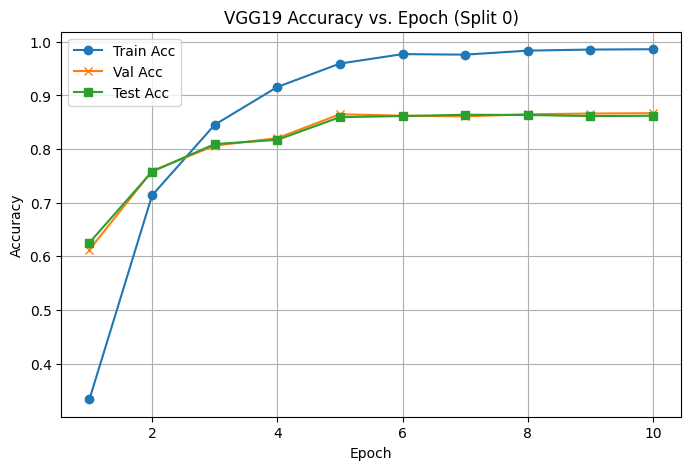

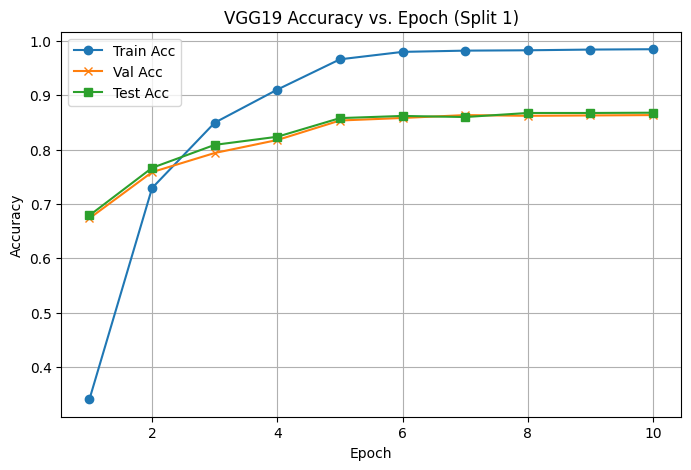

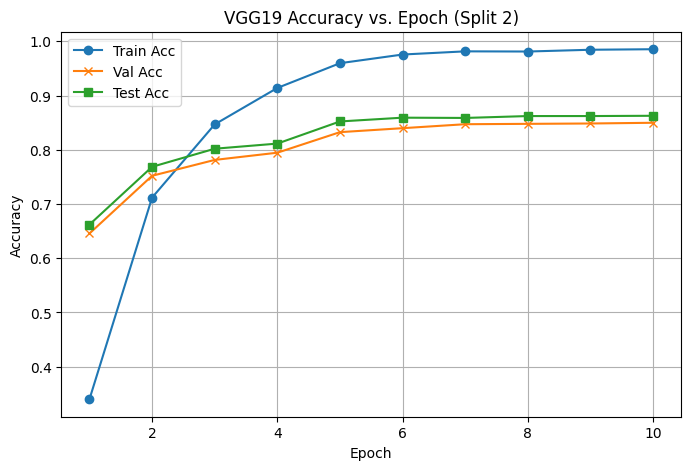

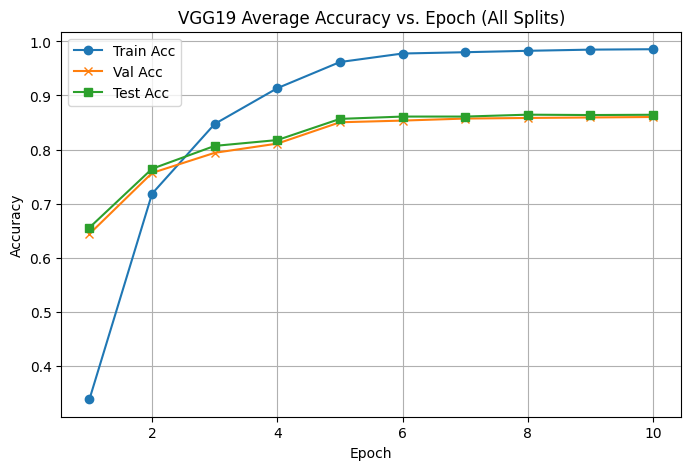

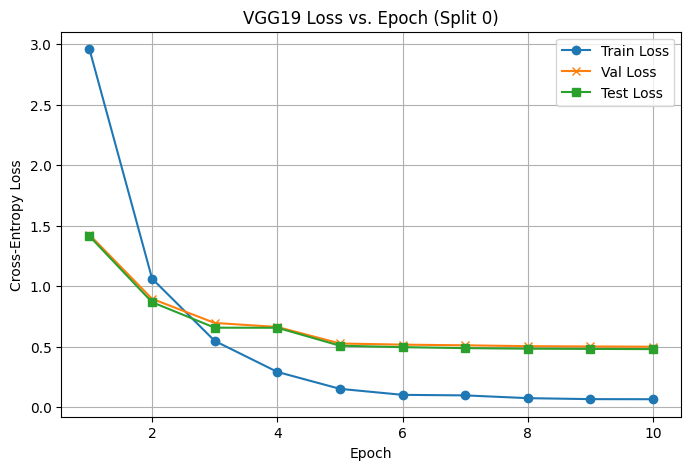

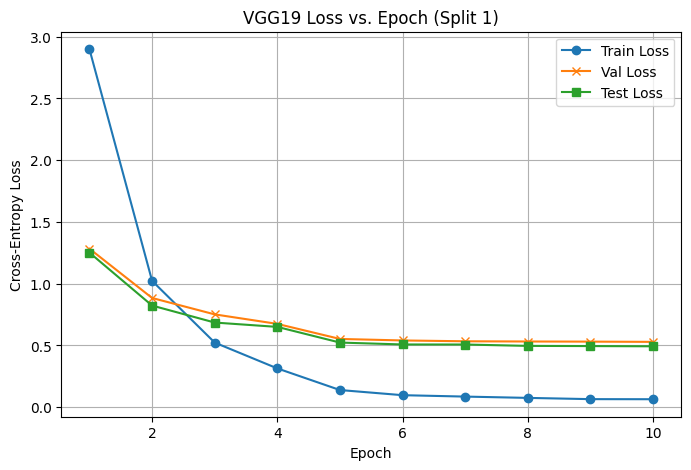

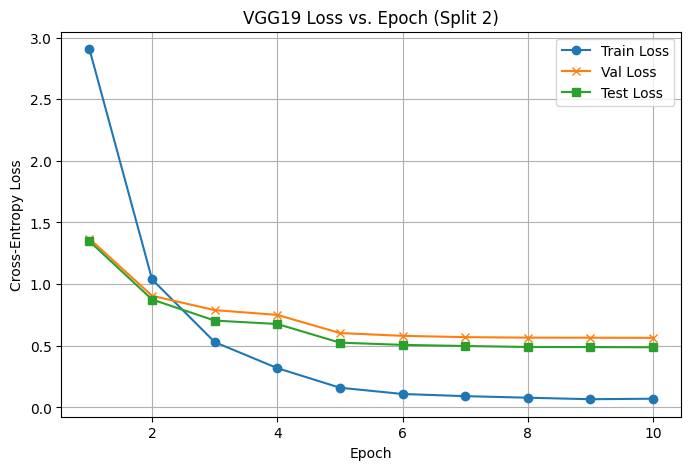

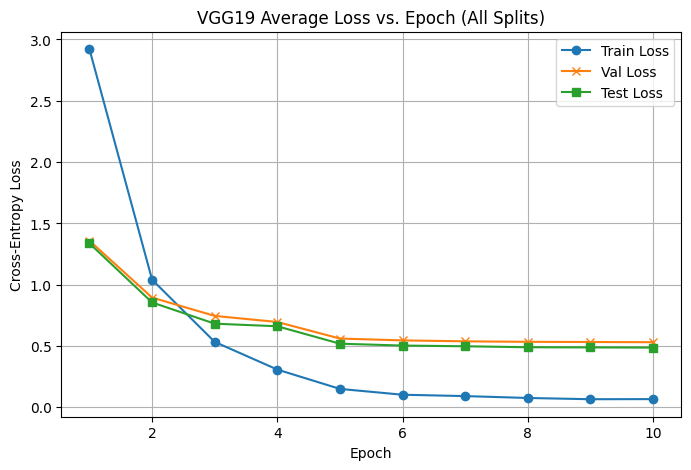


=========== YOLOv5: ALL SPLITS ===========

----- SPLIT 0 (YOLOv5) -----


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.01, bs=16, val_acc=0.8358


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.01, bs=32, val_acc=0.8757


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.001, bs=16, val_acc=0.9003


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.001, bs=32, val_acc=0.8830


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 


[Tuning] lr=0.0001, bs=16, val_acc=0.6177


Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.0001, bs=32, val_acc=0.4993
Best Hyperparams => LR=0.001, BatchSize=16, ValAcc=0.9003


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Epoch 1/10] TrainLoss=2.2131, TrainAcc=0.5735 | ValLoss=1.0160,   ValAcc=0.8225 | TestLoss=0.9974, TestAcc=0.8342
[Epoch 2/10] TrainLoss=0.6057, TrainAcc=0.9178 | ValLoss=0.6484,   ValAcc=0.8717 | TestLoss=0.6256, TestAcc=0.8880
[Epoch 3/10] TrainLoss=0.3263, TrainAcc=0.9625 | ValLoss=0.5117,   ValAcc=0.8963 | TestLoss=0.4915, TestAcc=0.9094
[Epoch 4/10] TrainLoss=0.2115, TrainAcc=0.9795 | ValLoss=0.4463,   ValAcc=0.9082 | TestLoss=0.4139, TestAcc=0.9159
[Epoch 5/10] TrainLoss=0.1456, TrainAcc=0.9928 | ValLoss=0.4304,   ValAcc=0.9076 | TestLoss=0.4003, TestAcc=0.9228
[Epoch 6/10] TrainLoss=0.1394, TrainAcc=0.9935 | ValLoss=0.4239,   ValAcc=0.9109 | TestLoss=0.3946, TestAcc=0.9214
[Epoch 7/10] TrainLoss=0.1311, TrainAcc=0.9958 | ValLoss=0.4184,   ValAcc=0.9122 | TestLoss=0.3895, TestAcc=0.9214
[Epoch 8/10] TrainLoss=0.1273, TrainAcc=0.9935 | ValLoss=0.4130,   ValAcc=0.9136 | TestLoss=0.3846, TestAcc=0.9214
[Epoch 9/10] TrainLoss=0.1210, TrainAcc=0.9945 | ValLoss=0.4126,   ValAcc=0.9129

Fusing layers... 


[Epoch 10/10] TrainLoss=0.1204, TrainAcc=0.9948 | ValLoss=0.4121,   ValAcc=0.9136 | TestLoss=0.3836, TestAcc=0.9214

----- SPLIT 1 (YOLOv5) -----


Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.01, bs=16, val_acc=0.8577


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.01, bs=32, val_acc=0.8797


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.001, bs=16, val_acc=0.8963


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.001, bs=32, val_acc=0.8890


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.0001, bs=16, val_acc=0.6097


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.0001, bs=32, val_acc=0.4927
Best Hyperparams => LR=0.001, BatchSize=16, ValAcc=0.8963


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Epoch 1/10] TrainLoss=2.2582, TrainAcc=0.5840 | ValLoss=1.0431,   ValAcc=0.8258 | TestLoss=1.0164, TestAcc=0.8263
[Epoch 2/10] TrainLoss=0.6251, TrainAcc=0.9097 | ValLoss=0.6806,   ValAcc=0.8783 | TestLoss=0.6469, TestAcc=0.8850
[Epoch 3/10] TrainLoss=0.3410, TrainAcc=0.9583 | ValLoss=0.5304,   ValAcc=0.8983 | TestLoss=0.4942, TestAcc=0.9104
[Epoch 4/10] TrainLoss=0.2167, TrainAcc=0.9827 | ValLoss=0.4736,   ValAcc=0.8976 | TestLoss=0.4338, TestAcc=0.9109
[Epoch 5/10] TrainLoss=0.1506, TrainAcc=0.9922 | ValLoss=0.4533,   ValAcc=0.9096 | TestLoss=0.4125, TestAcc=0.9174
[Epoch 6/10] TrainLoss=0.1443, TrainAcc=0.9941 | ValLoss=0.4451,   ValAcc=0.9109 | TestLoss=0.4036, TestAcc=0.9194
[Epoch 7/10] TrainLoss=0.1375, TrainAcc=0.9945 | ValLoss=0.4384,   ValAcc=0.9102 | TestLoss=0.3969, TestAcc=0.9189
[Epoch 8/10] TrainLoss=0.1332, TrainAcc=0.9958 | ValLoss=0.4326,   ValAcc=0.9122 | TestLoss=0.3911, TestAcc=0.9194
[Epoch 9/10] TrainLoss=0.1267, TrainAcc=0.9948 | ValLoss=0.4319,   ValAcc=0.9122

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Epoch 10/10] TrainLoss=0.1260, TrainAcc=0.9941 | ValLoss=0.4313,   ValAcc=0.9116 | TestLoss=0.3898, TestAcc=0.9194

----- SPLIT 2 (YOLOv5) -----


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.01, bs=16, val_acc=0.8398


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.01, bs=32, val_acc=0.8770


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.001, bs=16, val_acc=0.8963


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.001, bs=32, val_acc=0.8956


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Tuning] lr=0.0001, bs=16, val_acc=0.6283


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 


[Tuning] lr=0.0001, bs=32, val_acc=0.4801
Best Hyperparams => LR=0.001, BatchSize=16, ValAcc=0.8963


Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


[Epoch 1/10] TrainLoss=2.2343, TrainAcc=0.5840 | ValLoss=1.0375,   ValAcc=0.8358 | TestLoss=1.0318, TestAcc=0.8198
[Epoch 2/10] TrainLoss=0.6183, TrainAcc=0.9081 | ValLoss=0.6559,   ValAcc=0.8830 | TestLoss=0.6367, TestAcc=0.8850
[Epoch 3/10] TrainLoss=0.3402, TrainAcc=0.9576 | ValLoss=0.5218,   ValAcc=0.8949 | TestLoss=0.4979, TestAcc=0.9029
[Epoch 4/10] TrainLoss=0.2232, TrainAcc=0.9775 | ValLoss=0.4532,   ValAcc=0.9029 | TestLoss=0.4237, TestAcc=0.9139
[Epoch 5/10] TrainLoss=0.1496, TrainAcc=0.9935 | ValLoss=0.4363,   ValAcc=0.9082 | TestLoss=0.4065, TestAcc=0.9228
[Epoch 6/10] TrainLoss=0.1421, TrainAcc=0.9938 | ValLoss=0.4300,   ValAcc=0.9102 | TestLoss=0.3990, TestAcc=0.9248
[Epoch 7/10] TrainLoss=0.1356, TrainAcc=0.9954 | ValLoss=0.4237,   ValAcc=0.9116 | TestLoss=0.3932, TestAcc=0.9258
[Epoch 8/10] TrainLoss=0.1309, TrainAcc=0.9967 | ValLoss=0.4181,   ValAcc=0.9142 | TestLoss=0.3868, TestAcc=0.9278
[Epoch 9/10] TrainLoss=0.1248, TrainAcc=0.9964 | ValLoss=0.4174,   ValAcc=0.9156

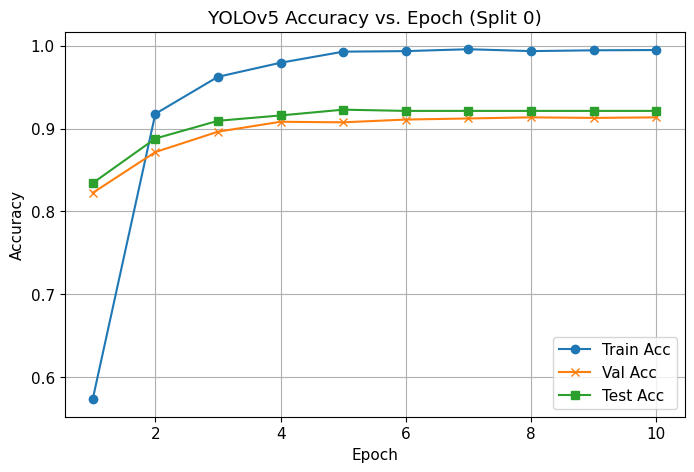

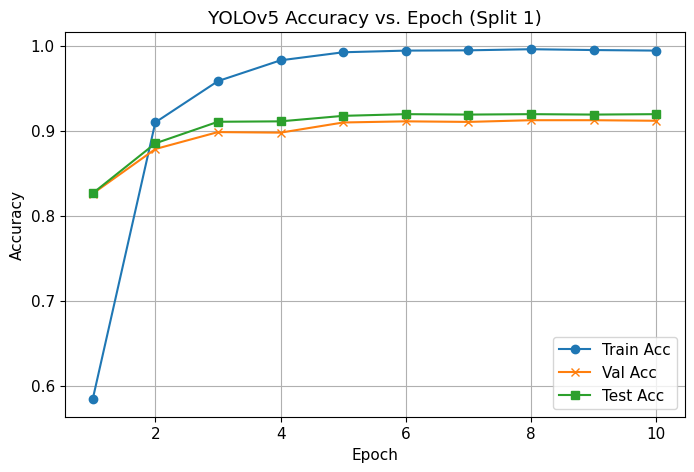

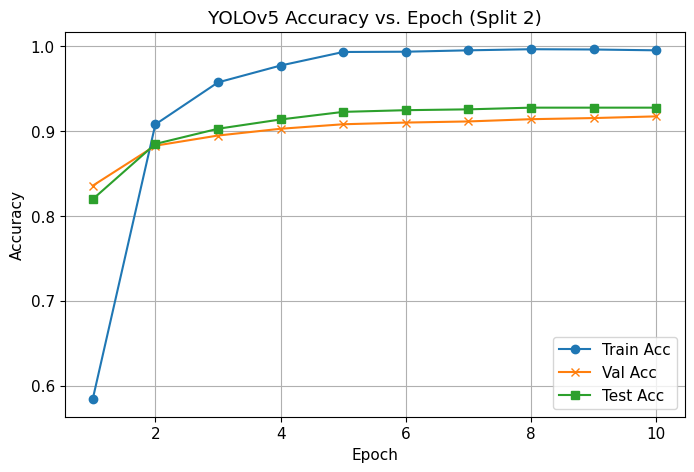

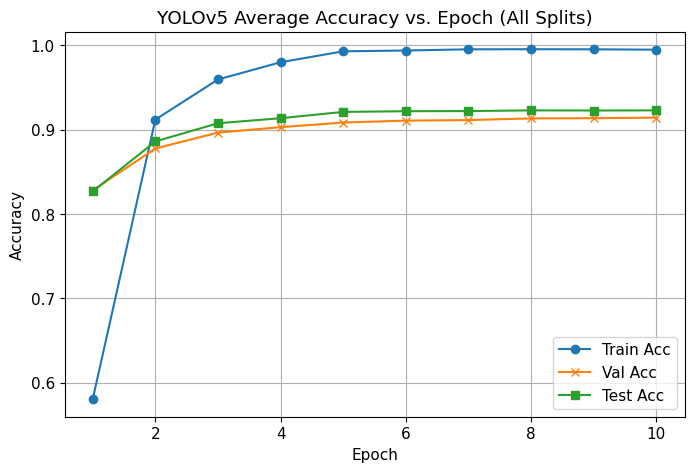

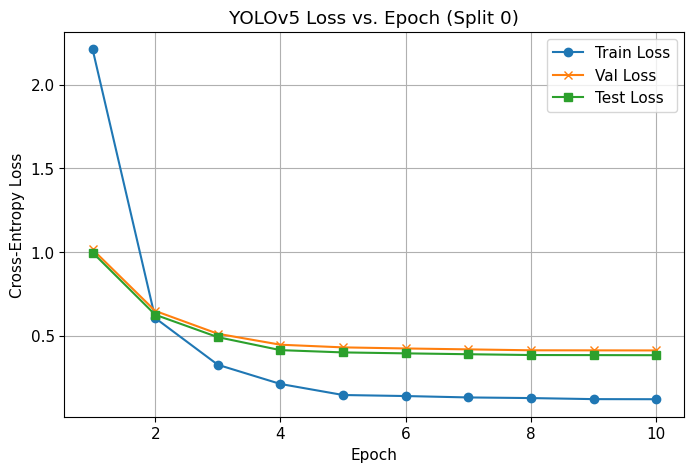

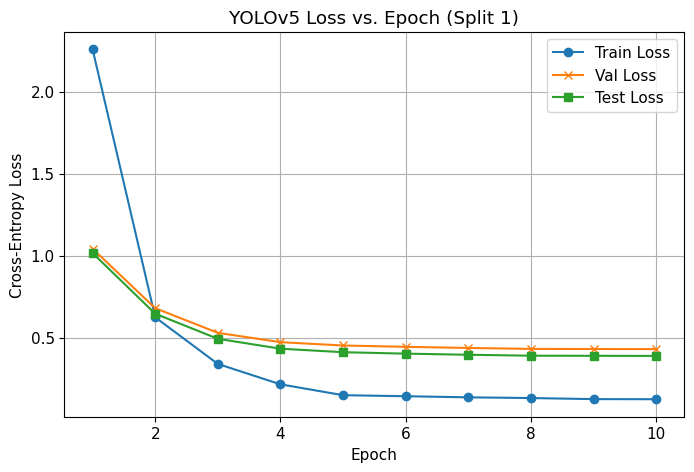

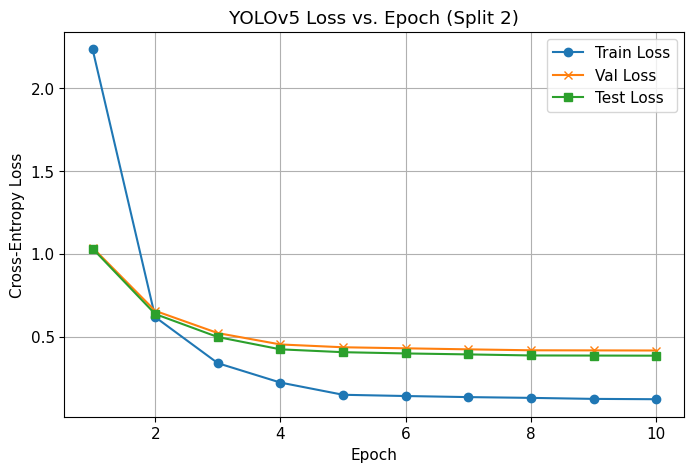

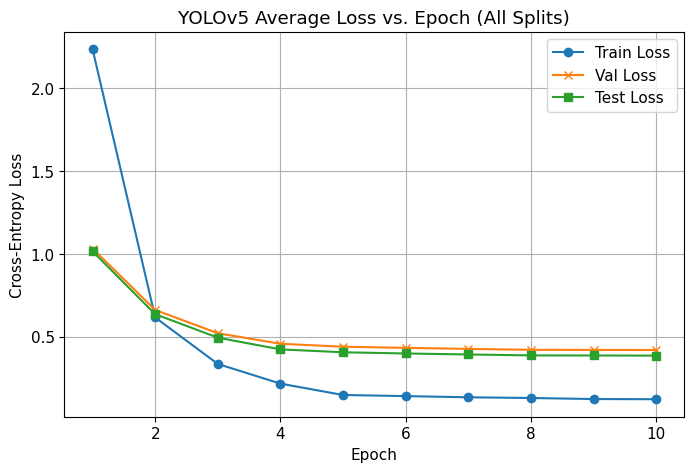


All done!


In [7]:
# ====================================================
# 6) MAIN FLOW
# ====================================================

def main():
    # We'll assume your function `prepare_dataset_fixed_test(...)`
    # has already created something like:
    # flower_data/
    #   fixed_test/
    #   train_val_split_0/train, train_val_split_0/val
    #   train_val_split_1/train, train_val_split_1/val
    #   ...

    num_splits = 3            # or however many you created
    tuning_epochs = 3         # we'll do 3 epochs for hyperparam tuning
    final_epochs = 10         # final full training epochs
    print(f"\nWill run {num_splits} splits, each with {final_epochs} final epochs.\n")

    # Standard transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # We'll load the fixed test set once
    fixed_test_dir = os.path.join("flower_data", "fixed_test")
    test_data = ImageFolder(fixed_test_dir, transform=transform)

    # A place to store results for each split
    vgg19_splits_results = []
    yolov5_splits_results = []

    print("\n=========== VGG19: ALL SPLITS ===========")
    # -- First do VGG19 on all splits --
    for split_idx in range(num_splits):
        print(f"\n----- SPLIT {split_idx} (VGG19) -----")
        train_dir = os.path.join("flower_data", f"train_val_split_{split_idx}", "train")
        val_dir   = os.path.join("flower_data", f"train_val_split_{split_idx}", "val")

        train_data = ImageFolder(train_dir, transform=transform)
        val_data   = ImageFolder(val_dir,   transform=transform)

        # 1) Hyperparam Tuning (3 epochs)
        best_lr_vgg, best_bs_vgg = hyperparam_tuning(build_model_vgg19, train_data, val_data, device,
                                                     tuning_epochs=tuning_epochs)

        # 2) Final Training (10 epochs)
        train_loader_vgg = DataLoader(train_data, batch_size=best_bs_vgg, shuffle=True)
        val_loader_vgg   = DataLoader(val_data,   batch_size=best_bs_vgg, shuffle=False)
        test_loader_vgg  = DataLoader(test_data,  batch_size=best_bs_vgg, shuffle=False)

        (train_losses_vgg, val_losses_vgg, test_losses_vgg,
         train_accs_vgg,   val_accs_vgg,   test_accs_vgg) = final_train_and_evaluate(
            build_model_vgg19, final_epochs,
            train_loader_vgg, val_loader_vgg, test_loader_vgg,
            device, lr=best_lr_vgg
        )

        vgg19_splits_results.append({
            "train_losses": train_losses_vgg,
            "val_losses":   val_losses_vgg,
            "test_losses":  test_losses_vgg,
            "train_accs":   train_accs_vgg,
            "val_accs":     val_accs_vgg,
            "test_accs":    test_accs_vgg
        })

    print("\n===== PLOTTING RESULTS FOR VGG19 (ALL SPLITS) =====")
    plot_splits_results(vgg19_splits_results, model_name="VGG19")

    print("\n=========== YOLOv5: ALL SPLITS ===========")
    # -- Then do YOLOv5 on all splits --
    for split_idx in range(num_splits):
        print(f"\n----- SPLIT {split_idx} (YOLOv5) -----")
        train_dir = os.path.join("flower_data", f"train_val_split_{split_idx}", "train")
        val_dir   = os.path.join("flower_data", f"train_val_split_{split_idx}", "val")

        train_data = ImageFolder(train_dir, transform=transform)
        val_data   = ImageFolder(val_dir,   transform=transform)

        # 1) Hyperparam Tuning (3 epochs)
        best_lr_yolo, best_bs_yolo = hyperparam_tuning(build_model_yolov5_wrapper, train_data, val_data, device,
                                                       tuning_epochs=tuning_epochs)

        # 2) Final Training (10 epochs)
        train_loader_yolo = DataLoader(train_data, batch_size=best_bs_yolo, shuffle=True)
        val_loader_yolo   = DataLoader(val_data,   batch_size=best_bs_yolo, shuffle=False)
        test_loader_yolo  = DataLoader(test_data,  batch_size=best_bs_yolo, shuffle=False)

        (train_losses_yolo, val_losses_yolo, test_losses_yolo,
         train_accs_yolo,   val_accs_yolo,   test_accs_yolo) = final_train_and_evaluate(
            build_model_yolov5_wrapper, final_epochs,
            train_loader_yolo, val_loader_yolo, test_loader_yolo,
            device, lr=best_lr_yolo
        )

        yolov5_splits_results.append({
            "train_losses": train_losses_yolo,
            "val_losses":   val_losses_yolo,
            "test_losses":  test_losses_yolo,
            "train_accs":   train_accs_yolo,
            "val_accs":     val_accs_yolo,
            "test_accs":    test_accs_yolo
        })

    print("\n===== PLOTTING RESULTS FOR YOLOv5 (ALL SPLITS) =====")
    plot_splits_results(yolov5_splits_results, model_name="YOLOv5")

    print("\nAll done!")

# Run the main
main()